# 05 – Data Analysis & Feature Engineering

In [1]:
from __future__ import annotations

import math

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from src.utils.part_anomaly import part_anomaly_fractions
from tqdm.auto import tqdm

sns.set_context('talk')
sns.set_style('darkgrid')

The **build_features.py** file essentially converts a **.hdf5** file of a build into a **.csv** one.

In [2]:
# !python -m src.utils.build_features \
#        --h5 "../data/2021-04-16 TCR Phase 1 Build 2.hdf5" \
#        --out "../data/build2_features.csv"

In [3]:
df = pd.read_csv("../data/build2_features.csv")

In [4]:
df.columns

Index(['layer', 'gas_oxygen', 'top_flow_rate', 'px_class_0', 'px_class_1',
       'total_px', 'absolute_image_capture_timestamp',
       'actual_ventilator_flow_rate', 'bottom_chamber_temperature',
       'bottom_flow_rate', 'bottom_flow_temperature', 'build_chamber_position',
       'build_plate_temperature', 'build_time', 'gas_loop_oxygen',
       'glass_scale_temperature', 'laser_rail_temperature', 'layer_times',
       'module_oxygen', 'powder_chamber_position',
       'target_ventilator_flow_rate', 'top_chamber_temperature',
       'top_flow_temperature', 'ventilator_speed', 'part_id', 'hatch_spacing',
       'laser_beam_power', 'laser_beam_speed', 'laser_module',
       'laser_spot_size', 'parameter_set', 'scan_rotation', 'stripe_width',
       'spatter_px', 'streak_px'],
      dtype='object')

In [5]:
df.head()

,layer,gas_oxygen,top_flow_rate,px_class_0,px_class_1,total_px,absolute_image_capture_timestamp,actual_ventilator_flow_rate,bottom_chamber_temperature,bottom_flow_rate,...,hatch_spacing,laser_beam_power,laser_beam_speed,laser_module,laser_spot_size,parameter_set,scan_rotation,stripe_width,spatter_px,streak_px
0,0,0.001020,97.533620,0,0,0,0.0,39.860813,30.0,39.853672,...,110.0,380.0,800.0,1.0,125.0,0,67.0,18.0,0,0
1,1,0.000960,96.303535,0,0,0,0.0,39.699055,30.0,39.701366,...,110.0,380.0,800.0,1.0,125.0,0,67.0,18.0,0,0
2,2,0.001818,97.156150,0,0,0,0.0,40.015420,30.0,40.001100,...,110.0,380.0,800.0,1.0,125.0,0,67.0,18.0,0,0
3,3,0.001572,97.300950,0,0,0,0.0,40.037292,30.0,40.037500,...,110.0,380.0,800.0,1.0,125.0,0,67.0,18.0,0,0
4,4,0.001136,97.340515,0,0,0,0.0,40.037132,30.0,40.050724,...,110.0,380.0,800.0,1.0,125.0,0,67.0,18.0,0,0


In [6]:
df_layer = df[["layer", "gas_oxygen", "top_flow_rate", "spatter_px", "streak_px"]]

In [7]:
df_layer.tail()

,layer,gas_oxygen,top_flow_rate,spatter_px,streak_px
3555,3555,0.026250,89.980810,39420,71982
3556,3556,0.024444,90.056114,44085,59080
3557,3557,0.026471,90.042030,39797,55411
3558,3558,0.025429,89.959210,38402,58964
3559,3559,0.027097,90.004130,48888,47892


### 1. Oxygen spikes vs next‑layer spatter

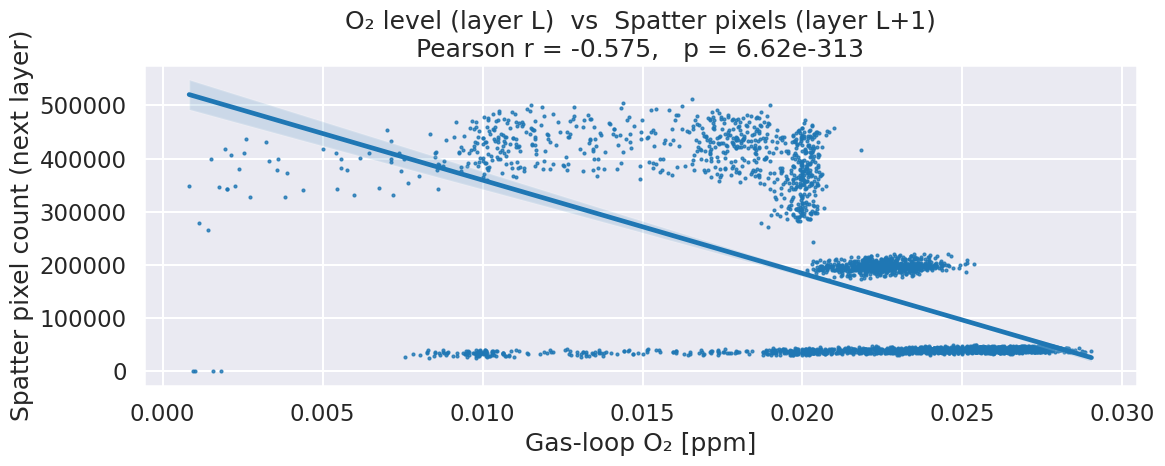

In [8]:
# Shift O₂ up by one layer so current‑layer oxygen predicts next‑layer spatter
df_q1 = (
    df_layer
    .assign(gas_oxygen_prev=df_layer["gas_oxygen"].shift(0),
            spatter_next   =df_layer["spatter_px"].shift(-1))
    .dropna()
)

r_oxy, p_oxy = pearsonr(df_q1["gas_oxygen_prev"], df_q1["spatter_next"])
title_txt = (
    "O₂ level (layer L)  vs  Spatter pixels (layer L+1)\n"
    f"Pearson r = {r_oxy:.3f},   p = {p_oxy:.3g}"
)

plt.figure(figsize=(12, 5))
sns.regplot(data=df_q1, x="gas_oxygen_prev", y="spatter_next",
            scatter_kws={"s": 4}, truncate=True)
plt.title(title_txt)
plt.xlabel("Gas-loop O₂ [ppm]")
plt.ylabel("Spatter pixel count (next layer)")
plt.tight_layout()
plt.show()

### 2. Low top‑flow rates vs recoater streaking

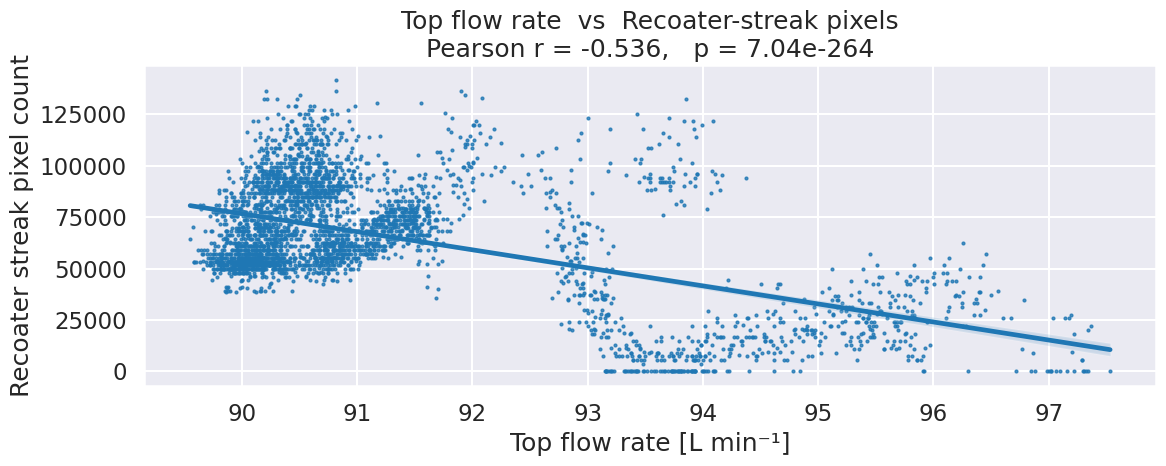

In [9]:
df_tmp = df_layer[["top_flow_rate", "streak_px"]].dropna()

r_flow, p_flow = pearsonr(df_tmp["top_flow_rate"], df_tmp["streak_px"])

plt.figure(figsize=(12, 5))
sns.regplot(
    data=df_tmp, x="top_flow_rate", y="streak_px",
    scatter_kws={"s": 4}, truncate=True
)
plt.title(
    "Top flow rate  vs  Recoater-streak pixels\n"
    f"Pearson r = {r_flow:.3f},   p = {p_flow:.3g}"
)
plt.xlabel("Top flow rate [L min⁻¹]")
plt.ylabel("Recoater streak pixel count")
plt.tight_layout()
plt.show()


### 3. Parts with lowest anomaly fraction

In [10]:
df_parts = part_anomaly_fractions("../data/build2_features.csv") 

In [11]:
df_parts.head()

,anomaly_frac,total_px,anomaly_px
part_id,,,
26,0.026797,27078385,725614
6,0.028002,270786442,7582670
38,0.028107,50772812,1427077
8,0.028201,13539194,381821
37,0.029121,10154447,295708


Add anomaly fraction per part to `df`.

In [12]:
df["anomaly_frac"] = df["part_id"].map(df_parts["anomaly_frac"])

# quick sanity check
display(df[["layer", "part_id", "anomaly_frac"]].tail())


,layer,part_id,anomaly_frac
3555,3555,28,0.034921
3556,3556,28,0.034921
3557,3557,28,0.034921
3558,3558,28,0.034921
3559,3559,28,0.034921


### 4. Tall part anomaly trend vs build height

In [13]:
# TALL_PARTS       = df_parts.index[-5:]          # or pick any list of PIDs
# layers_per_chunk = 16                           # match dataset.chunks[0] if possible


# with h5py.File(DATA_FILE, "r") as h5:
#     ds_part = h5["slices/part_ids"]
#     ds_spat = h5["slices/segmentation_results/8"]

#     n_layers, H, W = ds_part.shape
#     P               = len(TALL_PARTS)
#     tall_pids       = np.asarray(TALL_PARTS, dtype=ds_part.dtype)

#     # output: rows = layer, cols = tall part IDs
#     layer_spatter = np.zeros((n_layers, P), dtype=np.int64)

#     # reusable read buffers (one HDF5 chunk)
#     part_buf = np.empty((layers_per_chunk, H, W), dtype=ds_part.dtype)
#     spat_buf = np.empty_like(part_buf, dtype=bool)

#     rng = tqdm(range(0, n_layers, layers_per_chunk),
#                total=(n_layers + layers_per_chunk - 1) // layers_per_chunk,
#                desc="Streaming layers", unit="blk")

#     for start in rng:
#         stop   = min(start + layers_per_chunk, n_layers)
#         sl_out = slice(0, stop - start)               # length in this chunk

#         ds_part.read_direct(part_buf, source_sel=slice(start, stop), dest_sel=sl_out)
#         ds_spat.read_direct(spat_buf, source_sel=slice(start, stop), dest_sel=sl_out)

#         # Broadcast compare: (P, L, H, W)  boolean
#         match_pid = (part_buf[np.newaxis, :sl_out.stop] == tall_pids[:, None, None, None])
#         # Logical AND with spatter mask, then sum pixels → shape (P, L)
#         counts = np.logical_and(match_pid, spat_buf[np.newaxis, :sl_out.stop]).sum(axis=(2, 3))

#         # counts.T is (L, P) so we can drop straight into the big table
#         layer_spatter[start:stop] += counts.T

In [14]:
# df_tall = pd.DataFrame(layer_spatter, columns=TALL_PARTS)
# df_cum  = df_tall.cumsum()

In [15]:
# plt.figure(figsize=(10, 5))
# for pid in TALL_PARTS:
#     plt.plot(df_cum.index, df_cum[pid], label=f"Part {pid}")
# plt.xlabel("Layer number")
# plt.ylabel("Cumulative spatter pixels [count]")
# plt.title("Cumulative spatter vs build height (tall parts)")
# plt.legend()
# plt.tight_layout()
# plt.show()

### 5. Laser power / speed vs spatter occurrence

In [16]:
param_cols = ["part_id", "laser_beam_power", "laser_beam_speed"]

part_params = (
    df.loc[:, param_cols]          # (3560 × 3)
            .dropna(subset=["part_id"])   # safety
            .groupby("part_id", as_index=True)  # aggregate *per part*
            .first()                      # all layers of a part have same params
)

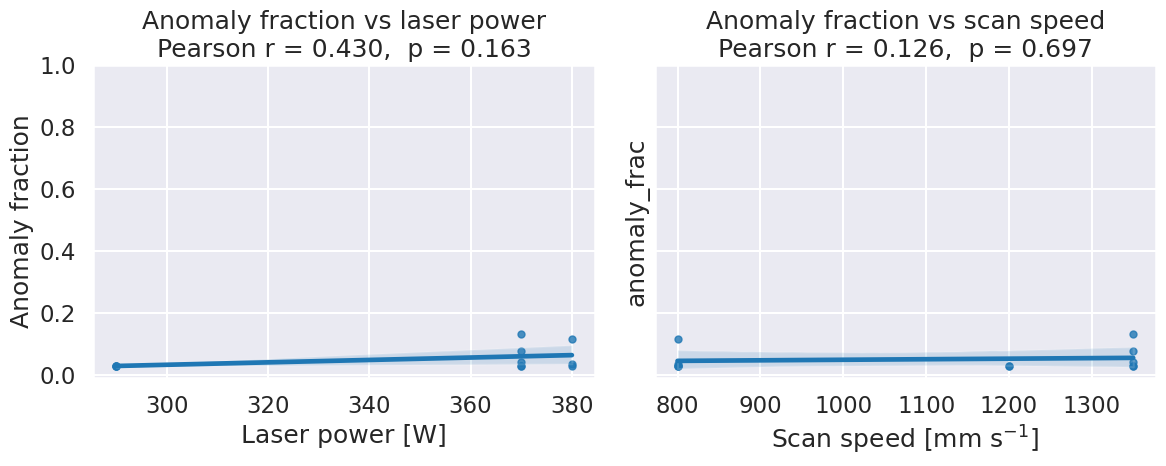

In [17]:
df_params = (
    df_parts.join(part_params, how="left")        # keeps the same index
               .rename(
                   columns={                      # nicer column names
                       "laser_beam_power": "laser_power",
                       "laser_beam_speed": "laser_speed",
                   }
               )
)

df_params = pd.DataFrame(
    {
        "anomaly_frac": df_parts["anomaly_frac"],
        "laser_power":  df_params["laser_power"],
        "laser_speed":  df_params["laser_speed"],
    },
    index=df_parts.index,
)

r_pwr, p_pwr = pearsonr(df_params["laser_power"], df_params["anomaly_frac"])
r_spd, p_spd = pearsonr(df_params["laser_speed"], df_params["anomaly_frac"])

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.regplot(
    data=df_params, x="laser_power", y="anomaly_frac",
    truncate=True, scatter_kws={"s": 25}, ax=ax[0]
)
ax[0].set(
    xlabel="Laser power [W]",
    ylabel="Anomaly fraction",
    ylim=(-0.01, 1.0),
    title=f"Anomaly fraction vs laser power\nPearson r = {r_pwr:.3f},  p = {p_pwr:.3g}",
)

sns.regplot(
    data=df_params, x="laser_speed", y="anomaly_frac",
    truncate=True, scatter_kws={"s": 25}, ax=ax[1]
)
ax[1].set(
    xlabel="Scan speed [mm s$^{-1}$]",
    ylim=(-0.01, 1.0),
    title=f"Anomaly fraction vs scan speed\nPearson r = {r_spd:.3f},  p = {p_spd:.3g}",
)

plt.tight_layout()
plt.show()

In [18]:
# # sanity: compare 3 random parts
# for pid in np.random.choice(df_parts.index, 3, replace=False):
#     print(pid, laser_power[pid-1], laser_speed[pid-1])

## 6. Physics‑Informed Analytics

This section implements **first‑order physics models** directly on the build logs and
segmentation outputs so we can test whether simple analytical theory aligns with observed anomalies.

> **Disclaimer** &nbsp; All constants are ballpark values for 316 L steel and a Concept Laser M2‑class
> machine. Adjust as needed for your exact material & machine.

In [19]:
# Physical constants 
R_GAS = 8.314            # J·mol⁻¹·K⁻¹
LAT_VAP = 6e6            # J·kg⁻¹  (approx latent heat of vaporisation)
A_RECOIL = 1e5           # Pa – empirical scaling
k_COND = 16              # W·m⁻¹·K⁻¹ thermal conductivity (solid, 316L)
ALPHA = 4e-6             # m²·s⁻¹ thermal diffusivity
LASER_RADIUS = 50e-6     # m (spot radius)
ABSORPTIVITY = 0.35      # fraction of P coupled to substrate
T_AMBIENT = 300          # K

# Gas properties 
rho_Ar = 1.6             # kg·m⁻³ at ~100 °C
rho_powder = 7800        # kg·m⁻³ (solid density proxy)
NOZZLE_AREA = 1.0e-3     # m² (placeholder cross‑section)

# Recoater properties 
L_BLADE = 0.25           # m (blade length)
E_BLADE = 200e9          # Pa (steel modulus)
I_BLADE = 1.5e-8         # m⁴ (estimated rectangular section)
LAYER_THICKNESS = 50e-6  # m

def rosenthal_Tmax(P: float, v: float, r: float = LASER_RADIUS) -> float:
    """Return peak melt‑pool surface temperature using a 2‑D Rosenthal approximation."""
    Q = ABSORPTIVITY * P  # effective absorbed power (W)
    deltaT = Q / (2 * math.pi * k_COND * r) * math.exp(-v * r / (2 * ALPHA))
    return T_AMBIENT + deltaT


def recoil_pressure(T_surf: float) -> float:
    """Approximate recoil pressure from Clausius–Clapeyron‑like exponential."""
    return A_RECOIL * math.exp(-LAT_VAP / (R_GAS * T_surf))


def plume_velocity(Q_l_min: float) -> float:
    """Argon volumetric flow `Q` (l/min) → plume advective velocity (m/s)."""
    Q_m3_s = Q_l_min / 1000 / 60  # convert to m³/s
    return Q_m3_s / NOZZLE_AREA * (1 - rho_powder / rho_Ar)


def blade_deflection(F_tip: float) -> float:
    """Tip deflection of a cantilever blade with end load F."""
    return F_tip * L_BLADE**3 / (3 * E_BLADE * I_BLADE)


### 8.1 Melt‑Pool Physics → Spatter Correlation

In [20]:
df.columns

Index(['layer', 'gas_oxygen', 'top_flow_rate', 'px_class_0', 'px_class_1',
       'total_px', 'absolute_image_capture_timestamp',
       'actual_ventilator_flow_rate', 'bottom_chamber_temperature',
       'bottom_flow_rate', 'bottom_flow_temperature', 'build_chamber_position',
       'build_plate_temperature', 'build_time', 'gas_loop_oxygen',
       'glass_scale_temperature', 'laser_rail_temperature', 'layer_times',
       'module_oxygen', 'powder_chamber_position',
       'target_ventilator_flow_rate', 'top_chamber_temperature',
       'top_flow_temperature', 'ventilator_speed', 'part_id', 'hatch_spacing',
       'laser_beam_power', 'laser_beam_speed', 'laser_module',
       'laser_spot_size', 'parameter_set', 'scan_rotation', 'stripe_width',
       'spatter_px', 'streak_px', 'anomaly_frac'],
      dtype='object')

In [21]:
# Compute per-part recoil pressure & correlate with anomaly fraction
df_phys = df.copy()

In [22]:
T_max_arr, P_recoil_arr = [], []
for idx, row in df_phys.iterrows():
    P, v = row['laser_beam_power'], row['laser_beam_speed']
    Tmax = rosenthal_Tmax(P, v)
    P_rec = recoil_pressure(Tmax)
    T_max_arr.append(Tmax)
    P_recoil_arr.append(P_rec)

df_phys['Tmax_K'] = T_max_arr
df_phys['P_recoil_Pa'] = P_recoil_arr
df_phys['high_recoil'] = df_phys['P_recoil_Pa'] > 1.0e5  # P_crit = 1 bar

In [23]:
df_phys[['laser_beam_power', 'laser_beam_speed', 'Tmax_K', 'P_recoil_Pa', 'anomaly_frac']].head()

,laser_beam_power,laser_beam_speed,Tmax_K,P_recoil_Pa,anomaly_frac
0,380.0,800.0,300.0,0.0,0.116506
1,380.0,800.0,300.0,0.0,0.116506
2,380.0,800.0,300.0,0.0,0.116506
3,380.0,800.0,300.0,0.0,0.116506
4,380.0,800.0,300.0,0.0,0.116506


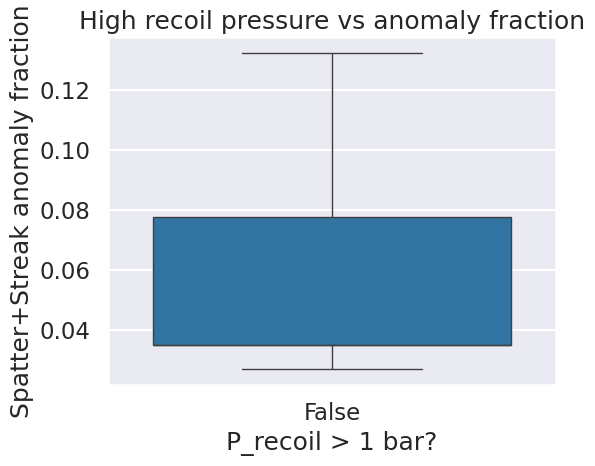

In [24]:
# Visualization
plt.figure(figsize=(6, 5))
sns.boxplot(x='high_recoil', y='anomaly_frac', data=df_phys)
plt.xlabel('P_recoil > 1 bar?')
plt.ylabel('Spatter+Streak anomaly fraction')
plt.title('High recoil pressure vs anomaly fraction')
plt.tight_layout()

In [25]:
df_phys.head()

,layer,gas_oxygen,top_flow_rate,px_class_0,px_class_1,total_px,absolute_image_capture_timestamp,actual_ventilator_flow_rate,bottom_chamber_temperature,bottom_flow_rate,...,laser_spot_size,parameter_set,scan_rotation,stripe_width,spatter_px,streak_px,anomaly_frac,Tmax_K,P_recoil_Pa,high_recoil
0,0,0.001020,97.533620,0,0,0,0.0,39.860813,30.0,39.853672,...,125.0,0,67.0,18.0,0,0,0.116506,300.0,0.0,False
1,1,0.000960,96.303535,0,0,0,0.0,39.699055,30.0,39.701366,...,125.0,0,67.0,18.0,0,0,0.116506,300.0,0.0,False
2,2,0.001818,97.156150,0,0,0,0.0,40.015420,30.0,40.001100,...,125.0,0,67.0,18.0,0,0,0.116506,300.0,0.0,False
3,3,0.001572,97.300950,0,0,0,0.0,40.037292,30.0,40.037500,...,125.0,0,67.0,18.0,0,0,0.116506,300.0,0.0,False
4,4,0.001136,97.340515,0,0,0,0.0,40.037132,30.0,40.050724,...,125.0,0,67.0,18.0,0,0,0.116506,300.0,0.0,False


### 8.2 Gas‑Flow Plume Velocity vs Spatter Dispersion

/tmp/ipykernel_47970/749330757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_layer['plume_v_ms'] = df_layer['top_flow_rate'].apply(plume_velocity)


Pearson r(plume_v, spatter_px) = -0.798, p-value = 0.000e+00


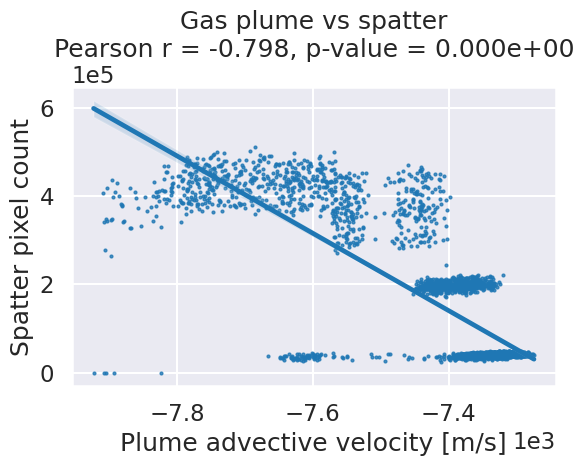

In [26]:
# Approximate plume velocity per layer 
df_layer['plume_v_ms'] = df_layer['top_flow_rate'].apply(plume_velocity)

corr_plume, p_value = pearsonr(df_layer['plume_v_ms'], df_layer['spatter_px'])
print(f'Pearson r(plume_v, spatter_px) = {corr_plume:.3f}, p-value = {p_value:.3e}')

plt.figure(figsize=(6, 5))
sns.regplot(x='plume_v_ms', y='spatter_px', data=df_layer, scatter_kws={'s': 4})
plt.xlabel('Plume advective velocity [m/s]')
plt.ylabel('Spatter pixel count')
plt.title(f'Gas plume vs spatter\nPearson r = {corr_plume:.3f}, p-value = {p_value:.3e}')

# Shorten axis values to scientific notation
plt.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))

plt.tight_layout()

### 8.3 Recoater Blade Deflection vs Streak Onset

/tmp/ipykernel_47970/2410731528.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_layer['tip_load_N'] = df_layer['streak_px'] * LOAD_PER_PX
/tmp/ipykernel_47970/2410731528.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_layer['blade_defl_m'] = df_layer['tip_load_N'].apply(blade_deflection)
/tmp/ipykernel_47970/2410731528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

88.1% of layers exceed powder thickness deflection


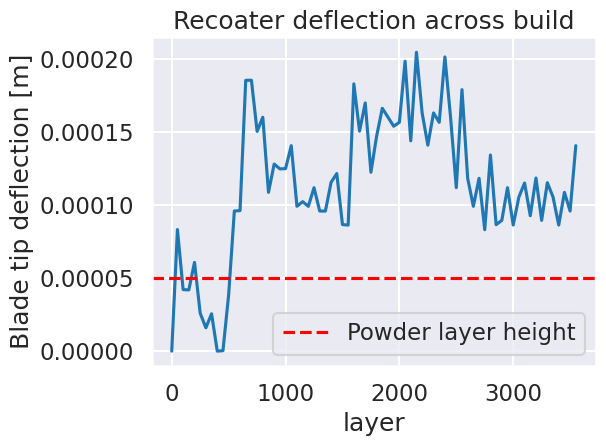

In [27]:
# Use anomaly‑height proxy: streak pixels translate to tip load
LOAD_PER_PX = 1e-3  # N per streak pixel (placeholder scaling)

df_layer['tip_load_N'] = df_layer['streak_px'] * LOAD_PER_PX
df_layer['blade_defl_m'] = df_layer['tip_load_N'].apply(blade_deflection)
df_layer['exceeds_powder'] = df_layer['blade_defl_m'] > LAYER_THICKNESS

prop_exceed = df_layer['exceeds_powder'].mean()
print(f'%.1f%% of layers exceed powder thickness deflection' % (100*prop_exceed))

sns.lineplot(x='layer', y='blade_defl_m', data=df_layer[::50])
plt.axhline(LAYER_THICKNESS, c='r', ls='--', label='Powder layer height')
plt.ylabel('Blade tip deflection [m]')
plt.title('Recoater deflection across build')
plt.legend();
plt.tight_layout()

### 8.4 Additional Metrics & Correlations

Aspect ratio  vs  spatter_frac   r = 0.706
Aspect ratio  vs  streak_frac    r = -0.390


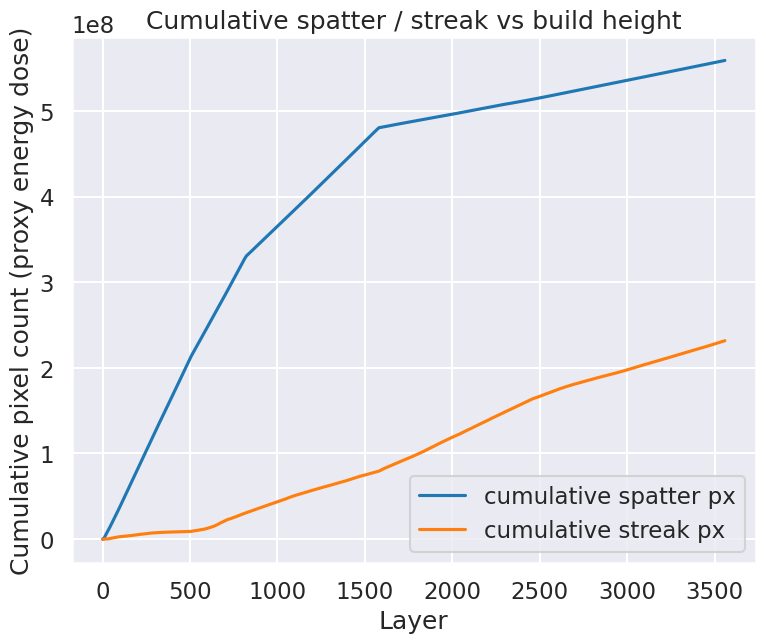

In [28]:
# ───────────────────────────────────────────────────────────────
# 1. Physics-based proxy features
# ───────────────────────────────────────────────────────────────
# energy density  [W·s m⁻³]   ( P / (v·hatch·layer_thk) )
layer_thk = 50e-6   # 50 µm layer thickness (m)
df_phys["energy_density"] = (
    df_phys["laser_beam_power"]
    / (df_phys["laser_beam_speed"] * df_phys["hatch_spacing"] * layer_thk)
)

# melt-pool aspect-ratio proxy – same empirical form you had
df_phys["aspect_ratio"] = (
    0.8 * np.sqrt(df_phys["energy_density"]) / (0.2 * df_phys["energy_density"])
)

# ───────────────────────────────────────────────────────────────
# 2. Convert pixel counts → fractions
# ───────────────────────────────────────────────────────────────
df_phys["spatter_frac"] = df_phys["spatter_px"] / df_phys["total_px"]
df_phys["streak_frac"]  = df_phys["streak_px"]  / df_phys["total_px"]

# ───────────────────────────────────────────────────────────────
# 3. Pearson correlations
# ───────────────────────────────────────────────────────────────
r_spat = df_phys["aspect_ratio"].corr(df_phys["spatter_frac"])
r_strk = df_phys["aspect_ratio"].corr(df_phys["streak_frac"])

print(f"Aspect ratio  vs  spatter_frac   r = {r_spat:.3f}")
print(f"Aspect ratio  vs  streak_frac    r = {r_strk:.3f}")

# ───────────────────────────────────────────────────────────────
# 4. Cumulative *spatter* and *streak* vs build height
#    (layer-indexed df_layer needed)
# ───────────────────────────────────────────────────────────────
cum_spat   = df_layer["spatter_px"].cumsum()
cum_streak = df_layer["streak_px"].cumsum()

fig, ax = plt.subplots(1, 1, figsize=(8, 7))
sns.lineplot(x=df_layer.index, y=cum_spat,   label="cumulative spatter px", ax=ax)
sns.lineplot(x=df_layer.index, y=cum_streak, label="cumulative streak px", ax=ax)

ax.set(
    xlabel="Layer",
    ylabel="Cumulative pixel count (proxy energy dose)",
    title="Cumulative spatter / streak vs build height",
)
ax.legend()
plt.tight_layout()

### 9. Feature Selection

In [29]:
# df_selected.to_csv('../data/selected_features.csv', index=False)

In [ ]:
# --- assume `df_phys` already contains every candidate feature column
#     plus the two REGRESSION targets -------------------------------
TARGETS      = ["spatter_px", "streak_px"]
EXCL_COLS    = ["layer", "part_id", "anomaly_frac", 
				"px_class_0", "px_class_1", "total_px", 
				"spatter_frac", "streak_frac"] + TARGETS # never use for corr
FEATURE_COLS = df_phys.columns.difference(EXCL_COLS).tolist()

# -------------------------------------------------------------------
# 1. make a correlation matrix: Pearson for linear, Spearman for rank
# -------------------------------------------------------------------
corr_pearson  = df_phys[FEATURE_COLS + TARGETS].corr(method="pearson")
corr_spearman = df_phys[FEATURE_COLS + TARGETS].corr(method="spearman")

# keep only feature-to-target rows
pearson_feat  = corr_pearson.loc[FEATURE_COLS, TARGETS]
spearman_feat = corr_spearman.loc[FEATURE_COLS, TARGETS]

# -------------------------------------------------------------------
# 2. combine both metrics into a single tidy frame
# -------------------------------------------------------------------
df_corr = (
    pearson_feat
      .rename(columns=lambda c: f"{c}_r")
      .merge(
          spearman_feat.rename(columns=lambda c: f"{c}_ρ"),
          left_index=True, right_index=True, how="left"
      )
      .assign(
          abs_max = lambda d: d[[f"{t}_r" for t in TARGETS] + 
                                [f"{t}_ρ" for t in TARGETS]].abs().max(axis=1)
      )
      .sort_values("abs_max", ascending=False)
      .rename_axis("feature")
)

# give each feature a rank (1 = strongest monotonic or linear relation)
df_corr["rank"] = np.arange(1, len(df_corr) + 1)

# display top 15
display(df_corr.head(15))

,spatter_px_r,streak_px_r,spatter_px_ρ,streak_px_ρ,abs_max,rank
feature,,,,,,
layer_times,0.963098,-0.597170,0.822802,-0.507248,0.963098,1
build_time,-0.920305,0.524536,-0.731254,0.256422,0.920305,2
powder_chamber_position,-0.907717,0.433340,-0.731254,0.256422,0.907717,3
build_chamber_position,-0.866263,0.358434,-0.731254,0.256422,0.866263,4
ventilator_speed,-0.822163,0.602912,-0.742664,0.290776,0.822163,5
stripe_width,-0.813742,0.428748,-0.811865,0.390884,0.813742,6
laser_beam_speed,0.807897,-0.433910,0.810319,-0.397197,0.810319,7
laser_spot_size,0.359309,-0.126000,0.807168,-0.381565,0.807168,8
parameter_set,0.803553,-0.445722,0.804930,-0.421482,0.804930,9


In [35]:
# # ── user-adjustable thresholds ────────────────────────────────────────────
# ALPHA    = 0.05   # p-value cut-off for significance
# ABS_MIN  = 0.05   # keep only correlations stronger than this magnitude
# # ──────────────────────────────────────────────────────────────────────────

# from scipy.stats import pearsonr, ConstantInputWarning
# import warnings, numpy as np, pandas as pd

# TARGETS       = ["spatter_px", "streak_px"]
# EXCLUDE_COLS  = ["layer", "part_id", "anomaly_frac",
#                  "px_class_0", "px_class_1", "total_px"] + TARGETS
# FEATURE_COLS  = df_phys.columns.difference(EXCLUDE_COLS).tolist()

# rows = []
# for tgt in TARGETS:
#     y = df_phys[tgt]

#     for feat in FEATURE_COLS:
#         x = df_phys[feat]

#         if x.nunique(dropna=False) <= 1:          # constant → skip
#             continue

#         with warnings.catch_warnings():
#             warnings.filterwarnings("error", category=ConstantInputWarning)
#             try:
#                 r, p = pearsonr(x, y)
#             except ConstantInputWarning:
#                 continue

#         rows.append(
#             {"feature": feat, "target": tgt,
#              "r": r, "p": p}
#         )

# df_corr = pd.DataFrame(rows)

# # ── significance / magnitude filter ───────────────────────────────────────
# df_sig = (
#     df_corr
#       .query("abs(r) >= @ABS_MIN and p < @ALPHA")
#       .copy()
# )

# selected = sorted(df_sig["feature"].unique())
# dropped  = sorted(set(FEATURE_COLS) - set(selected))

# print(f"Selected {len(selected)} features → {selected}")
# print(f"Dropped  {len(dropped)} features (|r| < {ABS_MIN} or p ≥ {ALPHA})")

# # ── wide view (features × targets) ----------------------------------------
# df_corr_wide = (
#     df_sig
#       .pivot_table(index="feature",
#                    columns="target",
#                    values=["r", "p"])
#       # optional: order by strongest r w.r.t spatter
#       .sort_values(("r", "spatter_px"), ascending=False)
# )

# display(df_corr_wide.head(15))     # top 15 by |r| for spatter


In [36]:
# export to CSV
df_corr.to_csv("../data/feature_correlations.csv", index=True)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.utils import check_random_state

TARGETS      = ["spatter_px", "streak_px"]
EXCL_COLS    = ["layer", "part_id", "anomaly_frac", 
				"px_class_0", "px_class_1", "total_px", 
				"spatter_frac", "streak_frac"] + TARGETS # never use for corr
FEATURE_COLS  = df_phys.columns.difference(EXCL_COLS).tolist()

# ensure purely numeric & no NaNs (MI cannot handle NaNs)
X_all = df_phys[FEATURE_COLS].apply(pd.to_numeric, errors="coerce").fillna(0).values

mi_rows = []
rng = check_random_state(42)   # reproducibility

for tgt in TARGETS:
    y = df_phys[tgt].to_numpy()

    mi = mutual_info_regression(
        X_all, y,
        n_neighbors=3,         # k-NN estimator (small k = fast)
        random_state=rng
    )

    mi_rows.extend(
        {"feature": f, "target": tgt, "MI": m}
        for f, m in zip(FEATURE_COLS, mi, strict=False)
    )

df_mi = (
    pd.DataFrame(mi_rows)
      .pivot_table(index="feature", columns="target", values="MI")
      .sort_values("spatter_px", ascending=False)      # order by spatter importance
)

display(df_mi.head(15))  # top 15 informative features for spatter

target,spatter_px,streak_px
feature,,
build_time,1.160899,1.148191
powder_chamber_position,1.140410,1.142652
layer_times,1.126828,0.576233
build_chamber_position,1.121144,1.143086
ventilator_speed,1.011519,0.898811
top_flow_rate,0.787653,0.617102
gas_oxygen,0.730875,0.528935
gas_loop_oxygen,0.729816,0.526220
bottom_flow_temperature,0.686187,0.577234


In [40]:
# export to CSV
df_mi.to_csv("../data/feature_importance.csv", index=True)

In [42]:
# ===============================================================
# 0.  Settings & prerequisite columns
# ===============================================================
from scipy.stats import pearsonr, spearmanr, ConstantInputWarning
from sklearn.feature_selection import mutual_info_regression
import warnings

TARGETS      = ["spatter_px", "streak_px"]
EXCL_COLS    = ["layer", "part_id", "px_class_0", "px_class_1", 
                "total_px"] + TARGETS           # never use for X
FEATURE_COLS = df_phys.columns.difference(EXCL_COLS).tolist()

# thresholds
ABS_R_MIN   = 0.10      # |r| must be ≥ this
PVAL_MAX    = 0.05      # …and p-value < this
MI_PCTL     = 0.80      # keep MI values in the top 20 %

# ===============================================================
# 1.  Pearson correlation  +  p-value
# ===============================================================
rows = []
for feat in FEATURE_COLS:
    x = df_phys[feat]
    # skip constant columns once – pearsonr/spearmanr would warn
    if x.nunique() <= 1:
        continue

    for tgt in TARGETS:
        y = df_phys[tgt]

        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConstantInputWarning)
            try:
                r, p_r = pearsonr(x, y)
            except ConstantInputWarning:
                continue

        rows.append(
            dict(feature=feat,
                 target=tgt,
                 metric_tag="pearson",
                 corr=r,
                 abs_corr=abs(r),
                 p_val=p_r)
        )

df_corr = pd.DataFrame(rows)

# keep only rows that surpass both |r| and p-value thresholds
df_corr_sig = df_corr.query("abs_corr >= @ABS_R_MIN and p_val < @PVAL_MAX")
print(f"✓ kept {len(df_corr_sig)} feature–target pairs by |r| & p-value")

# ===============================================================
# 2.  Mutual-information (non-linear dependency strength)
# ===============================================================
mi_rows = {}
for tgt in TARGETS:
    y = df_phys[tgt].to_numpy()

    # ── NEW: build X with NaNs replaced by column medians ──────────────
    X = (
        df_phys[FEATURE_COLS]
          .apply(lambda col: col.fillna(col.median()), axis=0)   # <- add this
          .to_numpy()
    )

    mi = mutual_info_regression(X, y, random_state=0)
    mi_rows[tgt] = mi

df_mi = (
    pd.DataFrame(mi_rows, index=FEATURE_COLS)    # rows = feat, cols = targets
      .fillna(0.0)
)
MI_cut = df_mi.stack().quantile(MI_PCTL)
print(f"✓ MI cut-off (80-th pct) = {MI_cut:.4f}")

# ===============================================================
# 3.  Build keep-list  (union of Pearson-gate & MI-gate)
# ===============================================================
pass_pear = df_corr_sig["feature"].unique()
pass_mi   = df_mi[df_mi.ge(MI_cut)].stack().index.get_level_values(0).unique()

KEEP_FEATS = sorted(set(pass_pear).union(pass_mi))
print(f"❯ Selected {len(KEEP_FEATS)} features  →  {KEEP_FEATS[:10]}…")

# ===============================================================
# 4.  Final dataframe for modelling
# ===============================================================
df_selected = df_phys[KEEP_FEATS + TARGETS].copy()
display(df_selected.head())


✓ kept 52 feature–target pairs by |r| & p-value
✓ MI cut-off (80-th pct) = 0.7224
❯ Selected 29 features  →  ['actual_ventilator_flow_rate', 'anomaly_frac', 'aspect_ratio', 'bottom_chamber_temperature', 'bottom_flow_rate', 'bottom_flow_temperature', 'build_chamber_position', 'build_plate_temperature', 'build_time', 'energy_density']…


,actual_ventilator_flow_rate,anomaly_frac,aspect_ratio,bottom_chamber_temperature,bottom_flow_rate,bottom_flow_temperature,build_chamber_position,build_plate_temperature,build_time,energy_density,...,powder_chamber_position,spatter_frac,streak_frac,stripe_width,top_chamber_temperature,top_flow_rate,top_flow_temperature,ventilator_speed,spatter_px,streak_px
0,39.860813,0.116506,0.430422,30.0,39.853672,49.0,0.00,30.0,0.000000,86.363636,...,0.000,NaN,NaN,18.0,29.0,97.533620,34.0,43.011856,0,0
1,39.699055,0.116506,0.430422,30.0,39.701366,49.0,0.05,30.0,0.093889,86.363636,...,0.250,NaN,NaN,18.0,29.0,96.303535,34.0,43.056046,0,0
2,40.015420,0.116506,0.430422,30.0,40.001100,49.0,0.10,30.0,0.138333,86.363636,...,0.375,NaN,NaN,18.0,29.0,97.156150,34.0,43.534748,0,0
3,40.037292,0.116506,0.430422,30.0,40.037500,49.0,0.15,30.0,0.180556,86.363636,...,0.500,NaN,NaN,18.0,29.0,97.300950,35.0,43.640102,0,0
4,40.037132,0.116506,0.430422,30.0,40.050724,49.0,0.20,30.0,0.224722,86.363636,...,0.625,NaN,NaN,18.0,29.0,97.340515,35.0,43.736618,0,0
